In [104]:
from googleapiclient import discovery
from googleapiclient.errors import HttpError
from glob import glob
import json
import numpy as np
import pandas as pd
import re
import time
from tqdm import tqdm

from helper import convert_perturbed_to_long

In [105]:
with open('/Users/lorenapiedras/Documents/credentials/api_creds.json', 'r') as file:
    api_keys = json.load(file)
API_KEY = api_keys['perspective_api']

In [106]:
score_type_map_full = {
    "toxicity_score": "TOXICITY",
    "identity_score": "IDENTITY_ATTACK",
    "insult_score": "INSULT",
    "threat_score": "THREAT",
    "sex_score": "SEXUALLY_EXPLICIT",
    "flirtation_score": "FLIRTATION"
}

score_type_map_toxicity = {
    "toxicity_score": "TOXICITY",
}

client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

def score_row(row, score_type_list, add_delay=False):
    if add_delay:
        time.sleep(1)
    try:
        score_type_attribute = {value: {} for value in score_type_list}
        analyze_request = {
            'comment': { 'text': row['sentence'] },
            'requestedAttributes': score_type_attribute
        }
        response = client.comments().analyze(body=analyze_request).execute()
    except HttpError as err:
        if err.resp.status == 429:
            print('Quota limit exceeded')
            time.sleep(10)
            response = client.comments().analyze(body=analyze_request).execute()
        else:
            raise
    value_list = []
    for score_type in score_type_list:
        value_list.append(
            response['attributeScores'][score_type]['summaryScore']['value'])
    return tuple(value_list)

# Toxicity Classification

In [4]:
run_from_scratch = False

In [109]:
data = pd.read_csv('../data/perturbed.csv')

In [12]:
if run_from_scratch:
    data = pd.read_csv('../data/perturbed.csv')

    data_long = convert_perturbed_to_long(data)

    batches = np.array_split(data_long, 30)

    for i, batch in enumerate(batches):
        batch = batch.assign(
            batch=i
        )
        batches[i] = batch
    
    df_batches = pd.concat(batches)
    df_batches.to_csv('../data/batches.csv', index=False)
else:
    print('Retreiving past batches')
    df_batches = pd.read_csv('../data/batches.csv')
    files = glob('../data/reddit_toxicity_*')
    processed_batches = [int(re.findall(r'[0-9]+',file)[0]) for file in files]
    non_processed_df = df_batches.loc[~df_batches.batch.isin(processed_batches)]
    batches = []
    for b in set(non_processed_df.batch.to_numpy()):
        batches.append(non_processed_df.query(f'batch == {b}'))

Retreiving past batches


In [15]:
score_col_names = list(score_type_map_toxicity.keys())
score_type_list = list(score_type_map_toxicity.values())
n = len(batches)
print(f'Running for {n} batches')
for i,batch in enumerate(tqdm(batches)):
    print(f'Running for batch {i}')
    results = batch.apply(lambda row: score_row(
        row, 
        score_type_list=score_type_list, 
        add_delay=True), axis=1, result_type='expand')
    results.columns = score_col_names
    batch = batch.join(results)
    n_batch = batch.batch.unique()[0]
    batch.to_csv(
        f'../data/reddit_toxicity_{n_batch}.csv',
        index=False
        )

Running for 2 batches


  0%|          | 0/2 [00:00<?, ?it/s]

Running for batch 0


 50%|█████     | 1/2 [16:35<16:35, 995.70s/it]

Running for batch 1


100%|██████████| 2/2 [33:12<00:00, 996.02s/it]


In [10]:
files = glob('../data/reddit_toxicity_*')
toxicity_scores = pd.concat([pd.read_csv(file) for file in files])
toxicity_scores.to_csv('../data/raw_toxicity_data.csv', index=False)

In [65]:
original_sentences = toxicity_scores.loc[
    toxicity_scores.variable == 'original_sentence']
modified_sentences = toxicity_scores.loc[
    toxicity_scores.variable != 'original_sentence']
original_sentences = original_sentences.filter(
    ['original', 'toxicity_score']).rename(columns={'toxicity_score':'original_toxicity'})

comparative_toxicity = pd.pivot(
    modified_sentences, 
    index=['op_gender', 'subreddit', 'original', 'category'],
    columns=['variable'],
    values=['sentence', 'toxicity_score']
    ).reset_index()

In [68]:
col_names = []
for col in comparative_toxicity.columns:
    if col[0] == 'toxicity_score':
        col_name = col[1] + '_'+ col[0]
    elif col[0] == 'sentence':
        col_name = col[1]
    else:
        col_name = col[0]
    col_names.append(col_name)

comparative_toxicity.columns = col_names

In [69]:
comparative_toxicity = comparative_toxicity.merge(
    original_sentences,
    on='original'
)

In [73]:
comparative_toxicity.to_csv('../data/toxicity_classification.csv', index=False)

# Sentiment Analysis

In [6]:
from helper import sample_analyze_sentiment

In [7]:
df_batches = pd.read_csv('../data/batches.csv')
files = glob('../data/reddit_sentiment_*')
processed_batches = [int(re.findall(r'[0-9]+',file)[0]) for file in files]
non_processed_df = df_batches.loc[~df_batches.batch.isin(processed_batches)]
batches = []
for b in set(non_processed_df.batch.to_numpy()):
    batches.append(non_processed_df.query(f'batch == {b}'))

In [8]:
for i,batch in enumerate(tqdm(batches)):
    n = batch.batch.unique()[0]
    print(f'Running for batch {n}')
    batch = batch.assign(
        sentiment_score=batch.sentence.map(
            lambda x: sample_analyze_sentiment(x))
            )
    batch.to_csv(f'../data/reddit_sentiment_{n}.csv')

  0%|          | 0/12 [00:00<?, ?it/s]

Running for batch 18


  8%|▊         | 1/12 [03:53<42:43, 233.06s/it]

Running for batch 19


 17%|█▋        | 2/12 [07:48<39:05, 234.58s/it]

Running for batch 20


 25%|██▌       | 3/12 [11:37<34:46, 231.78s/it]

Running for batch 21


 33%|███▎      | 4/12 [15:26<30:48, 231.01s/it]

Running for batch 22


 42%|████▏     | 5/12 [19:24<27:13, 233.38s/it]

Running for batch 23


 50%|█████     | 6/12 [23:13<23:11, 231.96s/it]

Running for batch 24


 58%|█████▊    | 7/12 [27:08<19:24, 232.96s/it]

Running for batch 25


 67%|██████▋   | 8/12 [31:02<15:33, 233.27s/it]

Running for batch 26


 75%|███████▌  | 9/12 [34:54<11:38, 232.79s/it]

Running for batch 27


 83%|████████▎ | 10/12 [38:41<07:42, 231.06s/it]

Running for batch 28


 92%|█████████▏| 11/12 [42:30<03:50, 230.41s/it]

Running for batch 29


100%|██████████| 12/12 [46:40<00:00, 233.42s/it]


In [24]:
files = glob('../data/reddit_sentiment_*')
sentiment_scores = pd.concat([pd.read_csv(file) for file in files])
sentiment_scores.to_csv('../data/raw_sentiment_data.csv', index=False)

In [25]:
original_sentences = sentiment_scores.loc[
    sentiment_scores.variable == 'original_sentence']
modified_sentences = sentiment_scores.loc[
    sentiment_scores.variable != 'original_sentence']
original_sentences = original_sentences.filter(
    ['original', 'sentiment_score']).rename(columns={'sentiment_score':'original_sentence_sentiment_score'})

comparative_sentiment = pd.pivot(
    modified_sentences, 
    index=['op_gender', 'subreddit', 'original', 'category'],
    columns=['variable'],
    values=['sentence', 'sentiment_score']
    ).reset_index()

In [26]:
col_names = []
for col in comparative_sentiment.columns:
    if col[0] == 'sentiment_score':
        col_name = col[1] + '_'+ col[0]
    elif col[0] == 'sentence':
        col_name = col[1]
    else:
        col_name = col[0]
    col_names.append(col_name)

comparative_sentiment.columns = col_names

In [27]:
comparative_sentiment = comparative_sentiment.merge(
    original_sentences,
    on='original'
)

In [28]:
comparative_sentiment.to_csv('../data/sentiment_classification.csv', index=False)

# Analysis

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
toxicity = pd.read_csv('../data/toxicity_classification.csv')
sentiment = pd.read_csv('../data/sentiment_classification.csv')

In [116]:
toxicity = toxicity.assign(
    score_diff_recommended =toxicity.recommended_sentence_toxicity_score - toxicity.original_toxicity,
    score_diff_not_recommended = toxicity.non_recommended_sentence_toxicity_score - toxicity.original_toxicity
)
sentiment = sentiment.assign(
    score_diff_recommended = sentiment.recommended_sentence_sentiment_score - sentiment.original_sentence_sentiment_score,
    score_diff_not_recommended = sentiment.non_recommended_sentence_sentiment_score - sentiment.original_sentence_sentiment_score
)

In [126]:
print('non rec:{}'.format(toxicity.score_diff_not_recommended.mean()))
print('rec:{}'.format(toxicity.score_diff_recommended.mean()))

non rec:0.13358023805388455
rec:0.09622199889300005


In [128]:
print('non rec:{}'.format(sentiment.score_diff_not_recommended.mean()))
print('rec:{}'.format(sentiment.score_diff_recommended.mean()))

non rec:-0.07033846244789087
rec:-0.0487769241470557


In [117]:
variable_name_map = {
    'score_diff_recommended': 'recommended',
    'score_diff_not_recommended': 'not recommended'
}
toxicity_plot = toxicity.melt(id_vars=['category'], value_vars=['score_diff_recommended', 'score_diff_not_recommended'])
toxicity_plot['variable'] = toxicity_plot.variable.map(variable_name_map)
sentiment_plot = sentiment.melt(id_vars=['category'], value_vars=['score_diff_recommended', 'score_diff_not_recommended'])
sentiment_plot['variable'] = sentiment_plot.variable.map(variable_name_map)

Text(0.5, 0, 'score_diff')

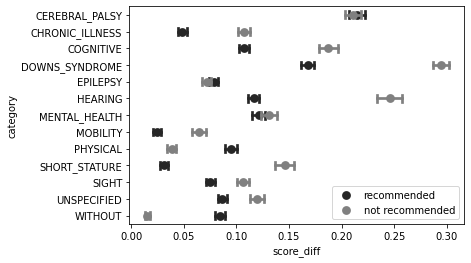

In [118]:
sns.pointplot(
    data=toxicity_plot, x="value", y="category", hue='variable',
    errorbar=("ci", 95), capsize=.4, join=False, color=".5",
)
plt.legend(title='')
plt.xlabel('score_diff')

Text(0.5, 0, 'score_diff')

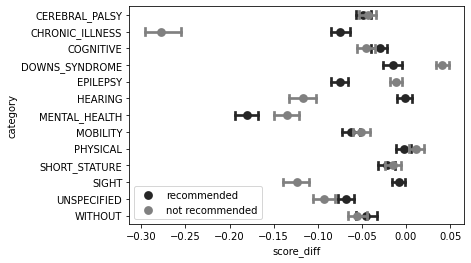

In [119]:
sns.pointplot(
    data=sentiment_plot, x="value", y="category", hue='variable',
    errorbar=("ci", 95), capsize=.4, join=False, color=".5",
)
plt.legend(title='')
plt.xlabel('score_diff')

In [245]:
q = '1 3 2 6 4 8 9 7 5 10 13 12 11 15 14 18 16 20 19 17 22 23 21 25 24 28 27 26 30 29 31 32 34 33 35 37 39 38 36 41 40 42 43 46 44 47 45 50 51 49 52 48 54 53 55 56 57 58 61 59 63 60 62 66 64 65 69 70 67 68 73 72 71 75 77 74 76 79 78 80 82 83 84 81 86 88 87 85 90 89 93 91 95 92 96 94 97 98 99 102 100 101 104 106 103 105 107 110 111 109 113 108 112 115 114 117 116 120 118 119 121 123 125 122 126 124 128 127 130 129 133 131 132 134 137 136 135 139 141 138 143 140 144 142 147 146 145 148 149 150 152 151 155 153 157 156 154 160 158 159 163 161 162 164 165 168 166 167 170 169 171 172 175 174 173 177 176 178 180 181 179 182 184 183 185 187 188 186 189 191 192 190 194 195 193 196 197 199 198 200 203 201 202 205 207 204 209 208 206 212 210 213 211 214 217 216 215 219 221 218 223 220 225 222 226 227 224 229 228 231 230 234 232 235 233 238 236 240 237 241 239 242 244 243 246 245 249 248 247 251 250 253 255 252 254 258 256 259 261 260 257 262 265 263 264 268 266 270 267 269 272 271 273 275 276 274 277 279 281 278 283 280 284 282 285 287 286 290 288 289 291 293 292 294 297 295 296 300 301 299 298 304 302 303 307 308 305 306 309 311 310 314 313 312 315 318 316 319 317 321 320 324 322 325 327 323 326 330 329 332 328 331 333 336 335 334 338 337 340 341 339 343 345 342 346 348 344 347 349 352 351 350 353 355 354 358 357 356 360 359 361 362 365 364 363 367 366 369 368 371 370 374 372 376 373 375 378 377 381 379 380 382 384 383 386 385 388 387 389 392 390 391 395 394 393 398 397 396 399 402 400 401 404 403 407 405 406 410 408 412 409 411 413 416 415 414 418 417 420 421 419 422 423 425 427 424 429 426 431 428 432 430 435 433 436 434 438 437 439 440 442 444 441 443 445 447 446 449 448 451 453 452 450 454 457 455 459 456 461 458 463 462 460 465 467 464 468 466 470 471 469 472 473 476 475 477 478 474 480 481 479 484 483 485 482 487 486 490 488 492 489 491 494 493 496 498 495 500 497 501 499 503 502 505 506 504 507 508 511 512 510 509 513 516 514 515 517 518 520 522 519 523 525 521 524 526 529 527 531 530 533 528 532 536 537 535 538 534 540 539 542 541 543 545 544 546 549 548 551 547 550 552 554 553 556 555 558 560 557 561 563 559 565 562 564 567 566 569 568 571 573 570 572 575 574 576 579 578 577 581 582 583 580 585 584 588 589 586 587 591 590 592 595 593 594 596 598 597 600 599 603 602 604 601 607 605 609 606 608 611 610 612 615 613 614 617 616 619 618 620 622 624 621 623 625 627 626 630 629 628 632 631 634 633 636 635 637 639 638 640 642 641 645 644 643 648 646 649 647 652 651 650 654 653 656 657 659 655 660 661 663 658 664 662 667 666 669 668 665 671 672 670 673 675 677 674 676 678 681 680 679 684 682 685 686 687 688 683 690 691 693 689 692 695 694 697 696 700 699 698 701 703 702 705 704 707 706 708 710 709 713 711 712 715 714 717 716 719 720 718 722 721 724 726 725 727 729 723 731 732 728 734 730 733 737 735 738 740 741 736 739 744 743 746 747 742 745 748 751 750 752 749 753 754 756 755 759 760 761 757 758 763 762 766 765 764 769 768 770 767 773 772 771 776 777 774 778 775 780 779 781 783 782 785 784 788 786 787 789 791 790 793 794 795 792 798 796 799 797 802 801 800 804 803 806 805 809 808 807 812 813 811 815 814 810 818 816 819 817 820 821 822 825 823 824 828 827 826 829 831 830 834 832 833 836 838 839 837 835 840 842 841 843 845 846 844 849 848 847 851 850 854 852 856 855 853 858 857 859 862 860 864 865 861 866 863 867 870 868 871 872 869 873 875 874 878 876 879 880 877 883 881 885 882 884 887 886 890 888 892 891 889 893 894 895 896 897 900 899 898 901 902 903 904 906 905 909 907 911 910 908 913 912 916 915 914 918 917 920 919 922 921 925 924 923 927 926 930 928 929 932 933 931 934 935 936 937 940 938 939 942 941 945 943 947 944 949 946 948 952 951 954 950 955 953 956 958 957 961 959 960 963 962 966 965 964 969 968 971 967 973 972 970 974 975 976 979 978 981 977 980 984 983 982 985 987 986 989 988 992 993 990 994 991 995 996 997'
q = q.split(' ')
q = list(map(int,q))

In [249]:
n_bribes = []
for i,pos in enumerate(q):
    bribes = 0
    if i+1 != pos:
        line_after = q[i+1:]
        for pos_after in line_after:
            if pos_after < pos:
                bribes += 1
    n_bribes.append(bribes)

In [251]:
sum(n_bribes)

648

In [236]:
sum(n_bribes)

44719

In [228]:
line_after

[]

In [254]:
current_order = [1,2,3,4,5,6,7]
current_order[6], current_order[5] = current_order[5], current_order[6]

In [260]:
list(range(4,1, -1))

[4, 3, 2]

In [294]:
target_order = [1,2,5,3,7,6,4]
current_order = [1,2,3,4,5,6,7]
n = len(current_order)
n_bribes = [0] * n
while target_order != current_order:
    for i in range(n):
        current = current_order[i]
        target = target_order[i]
        if current != target:
            for j in range(i+1, n):
                if current_order[j] == target_order[i]:
                    current_idx = j
                    for m in list(reversed(range(i+1,j+1))):
                        current_order[m-1], current_order[m] = current_order[m], current_order[m-1]
                        n_bribes[target-1] += 1
                    break

In [295]:
current_order = [1,2,3,4,5,6,7]
current_order[-3:]

[5, 6, 7]